**Hi! I’m Leonardo, an undergraduate Information Systems student with interest in Machine Learning and Data Science. If you’d like to learn more about my work, feel free to check my Linktree: https://linktr.ee/leoantero. Kind regards, Leo**


For this project I will build this project from zero with the book "Hands-on Machine Learning", where we'll predict the median house value using machine learning, including the data ETL, preprocessing, validation, etc.



#### First, we need to obtain the data

In [109]:
# Extracting the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # If the directory doesn't exist it creates
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [110]:
import pandas as pd

def load_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#### Now that we have our dataset let's take a look at the data

In [111]:
fetch_housing_data()
df = load_data()

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [112]:
df.info()

# That's good! 20.000 non-null instances

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [113]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Ocean proximity is our only non-numerical column but it has just 5 categories, that may be useful later.

In [114]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


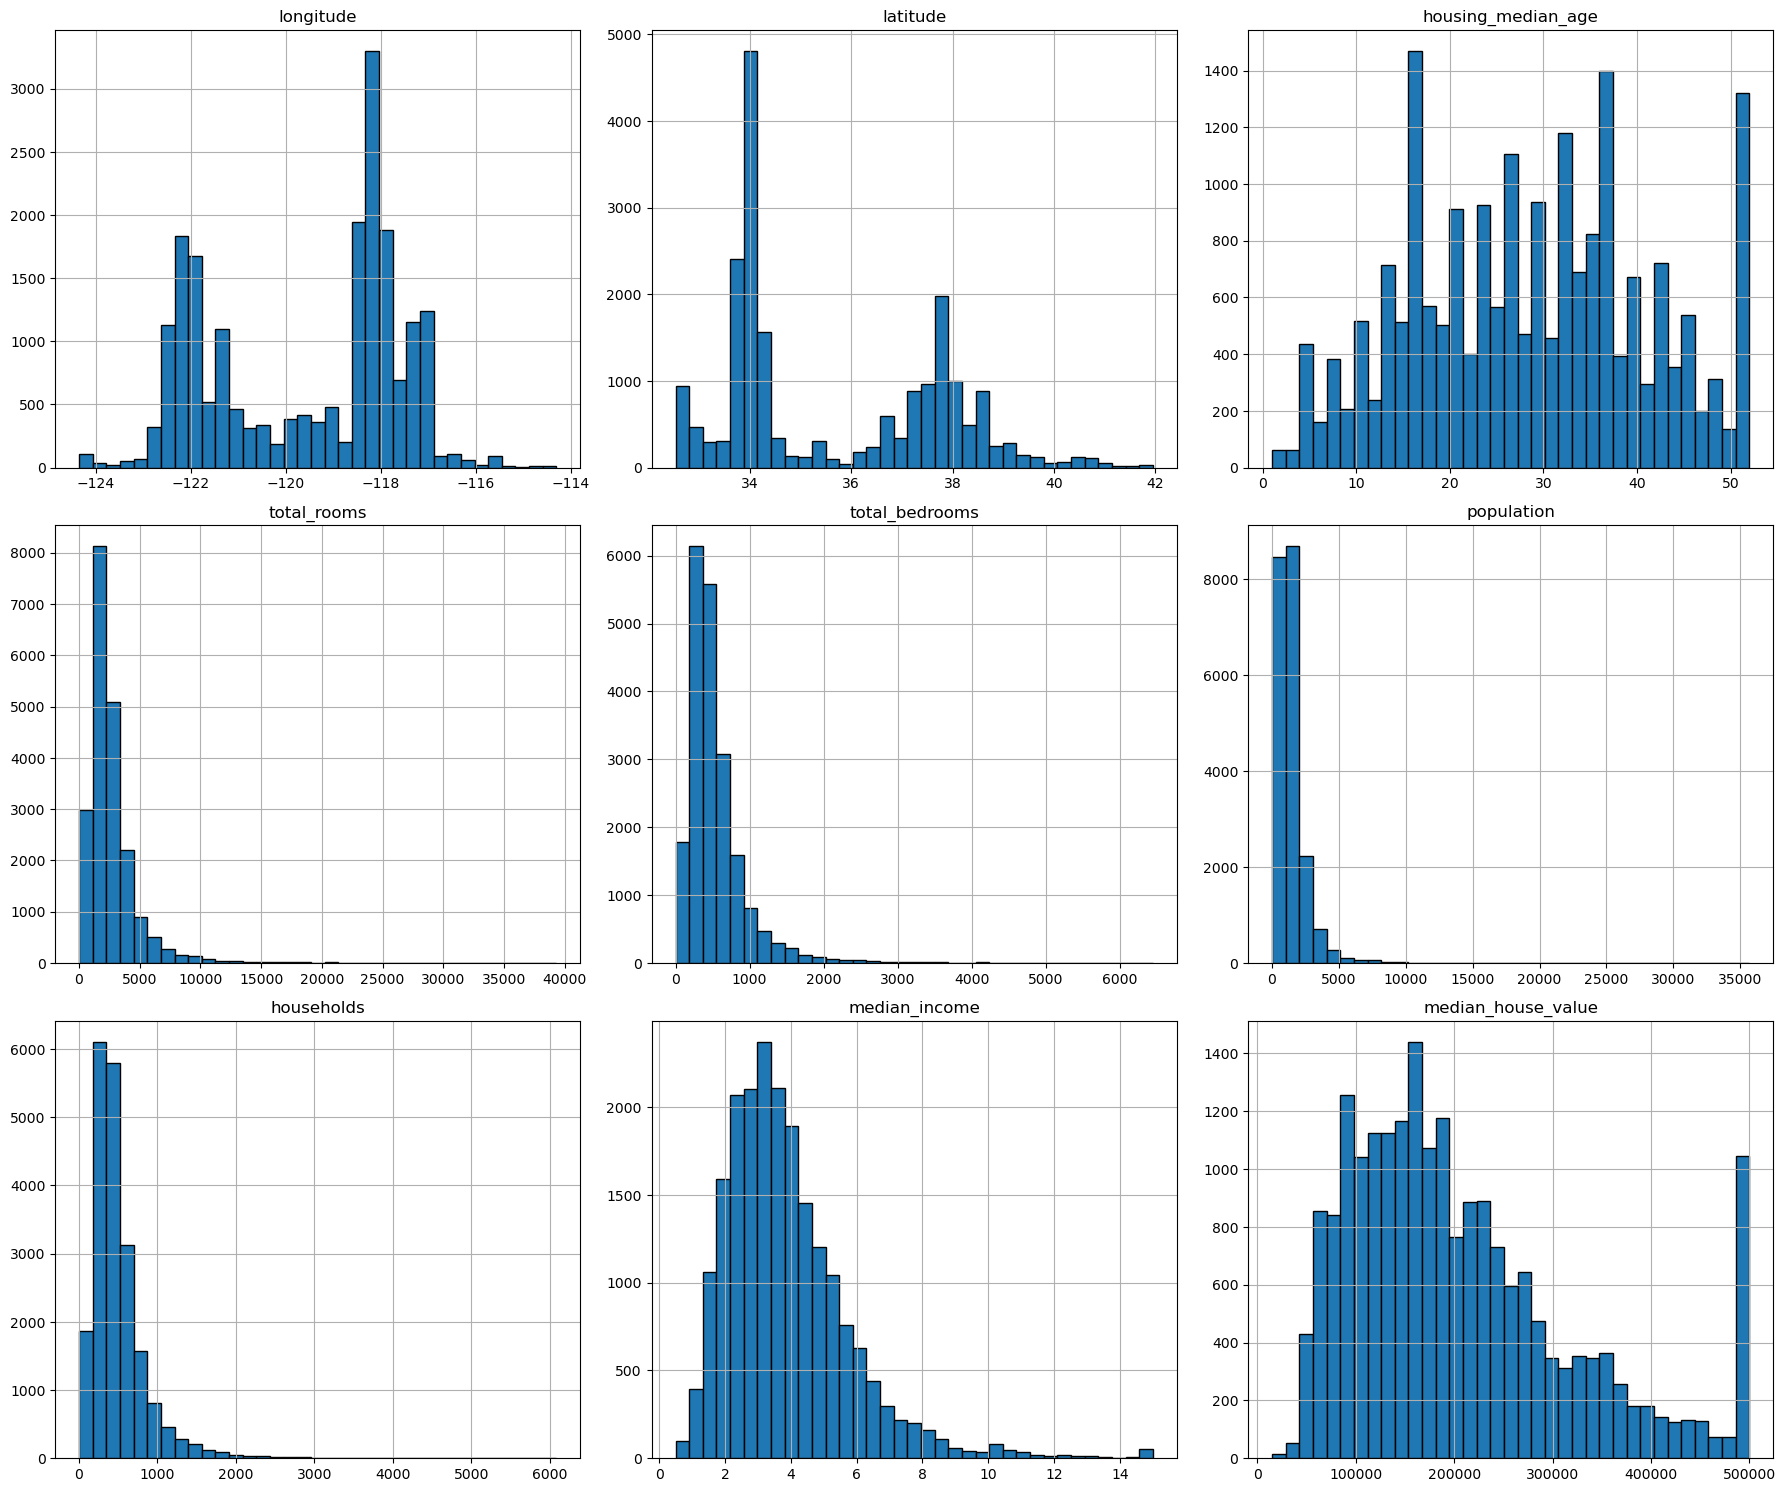

In [115]:
import matplotlib.pyplot as plt

df.hist(bins=35, figsize=(18, 15), grid=True, edgecolor='black')

plt.tight_layout(pad=1.0)
plt.show()

A lot of features has a characteristic called "tail heavy", where it has more data at the right side of the distribution peak.

#### Creating a test_sample and a train_sample


In [116]:
# To make this project reproducible many times with the same output we'll set this random seed 42 
import numpy as np

np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_idx = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_idx = shuffled_idx[:test_set_size]
    train_idx = shuffled_idx[test_set_size:]
    return data.iloc[train_idx], data.iloc[test_idx]

train_set, test_set = split_train_test(df, 0.3)

print(f"Test sample size:  {len(test_set)}")
print(f"Train sample size:  {len(train_set)}")

Test sample size:  6192
Train sample size:  14448


Even though scikit learn has a function called train_test_split, I'm writing because it's important to know how things works

In [117]:
"""
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.3, random_state = 42)
"""

'\nfrom sklearn.model_selection import train_test_split\n\ntrain_set, test_set = train_test_split(df, test_size=0.3, random_state = 42)\n'

<AxesSubplot:>

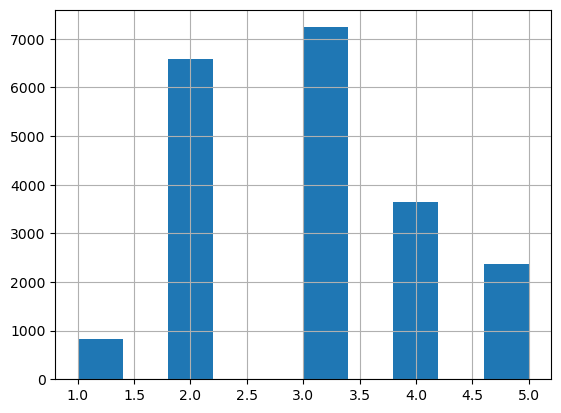

In [118]:
# Creating a new feature for the income category

df["income_cat"] = pd.cut(df["median_income"], 
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()

Let's make some stratified sampling based on this using the stratified class from sklearn

<AxesSubplot:>

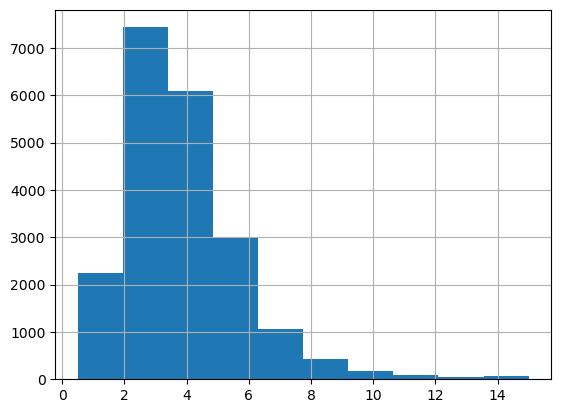

In [119]:
df['median_income'].hist()

<AxesSubplot:>

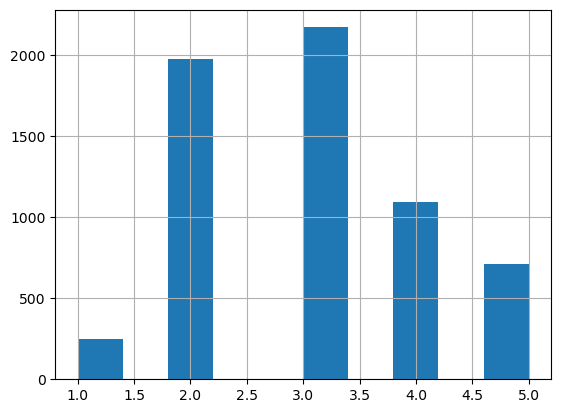

In [120]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_idx, test_idx in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_idx]
    strat_test_set = df.loc[test_idx]
    
# Let's analyse the samples proportion

strat_test_set['income_cat'].hist()

In [121]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: income_cat, dtype: float64

In [122]:
df['income_cat'].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

The sample is sucessfully stratified

In [123]:
# Now that our samples are sucessfully stratified based on a important feature, we'll remove the income_cat from the df

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

#### Then, we'll start with some EDA (Exploratory Data Analysis) with our training set and search for insights

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

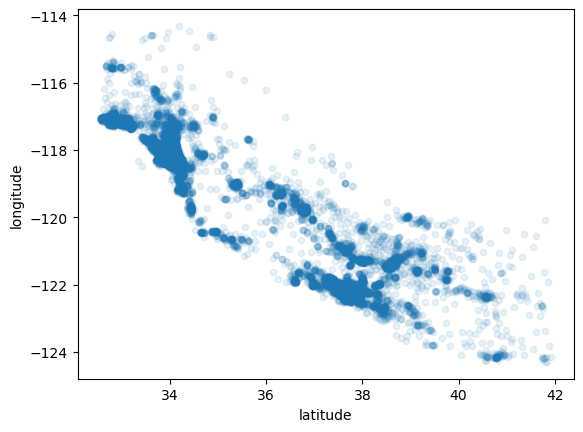

In [124]:
# Transforming the stratified train data into the main data we're gonna work with
housing = strat_train_set.copy()

housing.plot(kind='scatter',x='latitude', y='longitude', alpha=0.1)
# The alpha helps us to identify high density areas


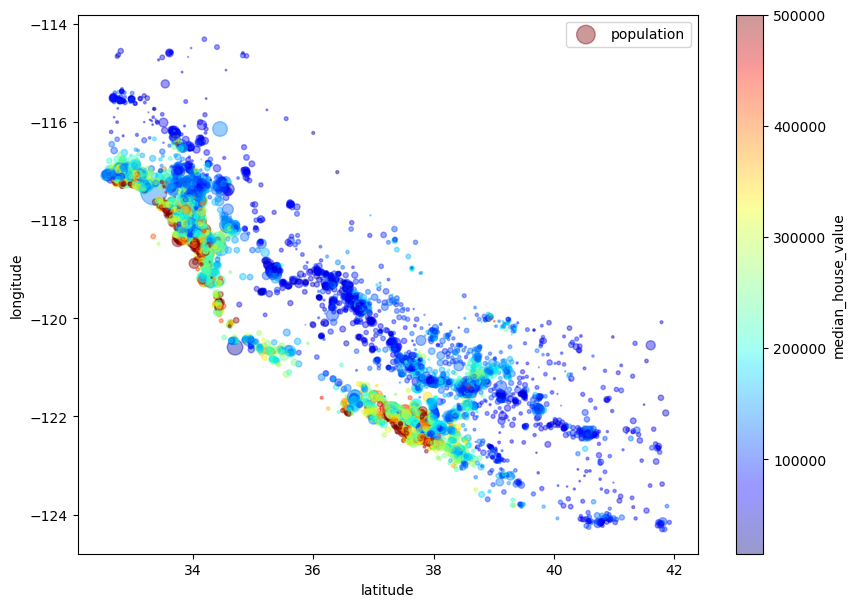

In [125]:
housing.plot(kind="scatter", x = "latitude", y = "longitude", alpha=0.4, 
            s = housing['population']/100, label = 'population', figsize=(10,7),
            c = 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

This image indicates that the house value is highly related to it's proximity with the sea and the population density

#### Exploring the data correlations

In [126]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687873
total_rooms           0.136801
housing_median_age    0.116305
households            0.066788
total_bedrooms        0.049523
population           -0.024592
longitude            -0.052345
latitude             -0.137864
Name: median_house_value, dtype: float64

The pandas function scatter matrix is also an altenative, but needs to be used wisely because it plots n² images, since it is calculating the correlation of every variable with each other


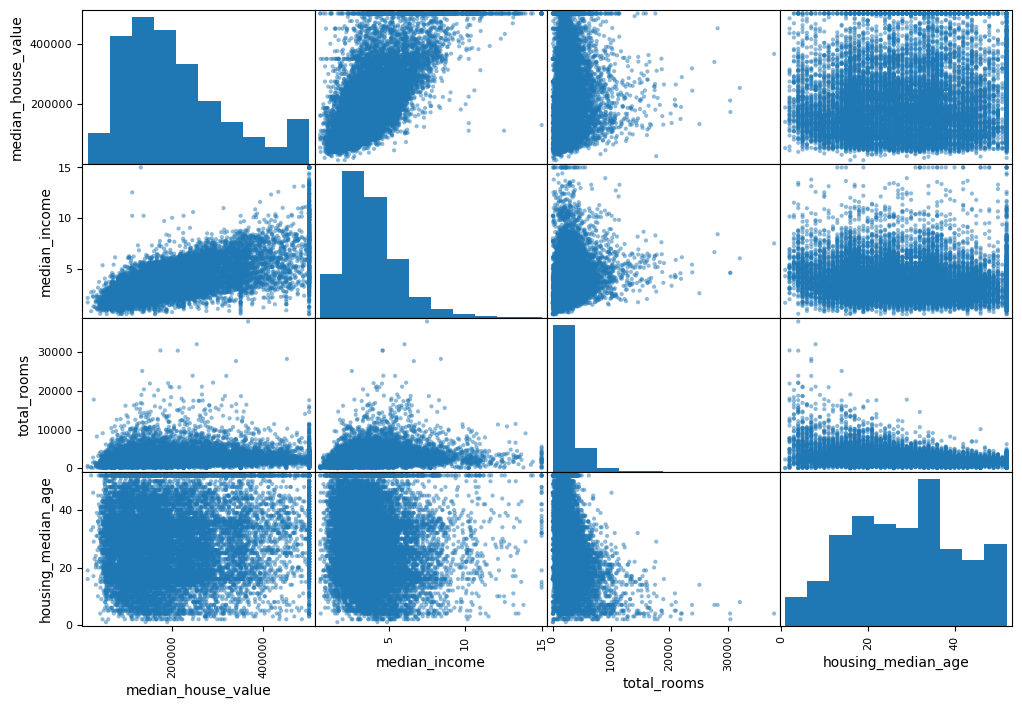

In [127]:
from pandas.plotting import scatter_matrix
pandas_scatter = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[pandas_scatter], figsize=(12, 8));

#### Doing a little bit more of feature engineering so maybe we can find some helpful informations

For instance, it's intersting to know about 'rooms per household' because this tells a lot about the house size and price

In [128]:
# Creating these 3 attributes combinations
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687873
rooms_per_household         0.144427
total_rooms                 0.136801
housing_median_age          0.116305
households                  0.066788
total_bedrooms              0.049523
population_per_household   -0.024005
population                 -0.024592
longitude                  -0.052345
latitude                   -0.137864
bedrooms_per_room          -0.262723
Name: median_house_value, dtype: float64

In [129]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,14448.000000,14448.000000,14448.000000,14448.000000,14308.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14308.000000,14448.000000
mean,-119.573294,35.633523,28.742594,2613.580565,533.261672,1413.560839,495.297204,3.873148,207143.478890,5.441096,0.212681,3.046520
std,2.003203,2.132504,12.574925,2125.841046,412.858965,1114.876264,376.039520,1.893996,115558.181448,2.458710,0.056676,10.554425
min,-124.300000,32.550000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.810000,33.940000,18.000000,1438.000000,294.000000,780.000000,278.000000,2.564375,120000.000000,4.444707,0.175368,2.432207
50%,-118.510000,34.260000,29.000000,2111.000000,430.000000,1159.000000,406.000000,3.536000,179900.000000,5.233582,0.202962,2.817653
75%,-118.010000,37.720000,37.000000,3121.500000,641.000000,1708.000000,598.000000,4.742600,263900.000000,6.058147,0.239579,3.280302
max,-114.310000,41.920000,52.000000,37937.000000,5471.000000,35682.000000,5189.000000,15.000100,500001.000000,132.533333,1.000000,1243.333333


#### And now, it's the data preprocessing time

In [130]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [131]:
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy="median")
housing_only_num = housing.drop("ocean_proximity", axis = 1)

impute.fit(housing_only_num)

SimpleImputer(strategy='median')

In [132]:
impute.statistics_

array([-118.51 ,   34.26 ,   29.   , 2111.   ,  430.   , 1159.   ,
        406.   ,    3.536])

In [133]:
X = impute.transform(housing_only_num)
housing_fix = pd.DataFrame(X, columns = housing_only_num.columns)

Since a lot of ML algorithms work better with numeric data, we need to convert the text feature into a numeric feature.
So, we will use a technique called encoding to convert. 

Here, we'll use one-hot encoding to give make this feature binary

In [153]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [154]:
cat_encoder.categories_

# Attribute categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Creating a transformer to add extra attributes

In [158]:
from sklearn.base import BaseEstimator, TransformerMixin

# The columns index
col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household] 
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attr_adder.transform(housing.values)

Our data has a very common problem, some features have very different variance, this isn't good for the model because the scale between variables doesn't match. So, we need to do feature scaling to adapt the data 

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_fix)

In [138]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_fix)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_final = full_pipeline.fit_transform(housing)

#### Training and choosing a model

In [139]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(housing_final, housing_labels)

LinearRegression()

In [161]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

predd = linear_regression.predict(some_data_prepared)
print("Predictions: ", predd)

Predictions:  [374178.99111712 201980.40760298 176111.53526793 169535.38547485
 267767.44978406]


In [160]:
print("Labels: ", list(some_labels))

Labels:  [500001.0, 203000.0, 192500.0, 121900.0, 250000.0]


In [140]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_final, housing_labels)

DecisionTreeRegressor()

#### Evaluation using K-folds

For the validation we may use K-fold cross validation because it's a very reliable feature since you compare different training data with differente testing data

In [141]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_final, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_score = np.sqrt(-scores)

In [142]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation", scores.std())

Scores: [-4.76868961e+09 -5.22545025e+09 -5.25453752e+09 -4.98635150e+09
 -5.22698895e+09 -4.80719657e+09 -5.49113914e+09 -5.04779225e+09
 -5.16763358e+09 -5.45453159e+09]
Mean: -5143031096.913815
Standard deviation 230570570.8546365


These stats means our model is overfitting the data

In [143]:
ln_scores = cross_val_score(linear_regression, housing_final, housing_labels, scoring="neg_mean_squared_error", cv = 10)
ln_rmse_score = np.sqrt(-ln_scores)
print("Scores:", ln_rmse_score)
print("Mean:", ln_rmse_score.mean())
print("Standard deviation", ln_rmse_score.std())

Scores: [65830.38815027 77056.74494539 64126.62164766 70328.71895431
 68303.09942861 70916.94402158 70104.24228447 65102.15137703
 69723.40940468 71281.95671343]
Mean: 69277.42769274325
Standard deviation 3549.7435833866493


Now, let's try other model to see the difference between then and continue searching the one that fits better to our problem

In [144]:
# Model import
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(housing_final, housing_labels)

# Validation
rf_scores = cross_val_score(random_forest, housing_final, housing_labels, scoring="neg_mean_squared_error", cv = 10)
rf_rmse_score = np.sqrt(-rf_scores)

print("Random Forest Scores: ", rf_rmse_score)
print("Random Forest Mean: ", rf_rmse_score.mean())
print("Random Forest Standard deviation", rf_rmse_score.std())

Random Forest Scores:  [48387.1763299  52162.69978969 46675.29837353 51995.56558868
 51523.39843471 50421.62475771 50838.41751752 47944.90576673
 50662.75729866 52425.29779066]
Random Forest Mean:  50303.71416478009
Random Forest Standard deviation 1874.517368147733


In [164]:
from sklearn.svm import SVR

svm_reg = SVR(kernel = 'linear')
svm_reg.fit(housing_final, housing_labels)
svm_pred = svm_reg.predict(housing_final)

svm_mse = mean_squared_error(housing_labels, svm_pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111844.33303412338

#### Fine-tuning

To improve our models perfomance we should fine-tune them, that's it, by working with better hyperparameters, 

In [145]:
# One way to do this it's with grid search, a tool that helps to find the best hyperparameter

from sklearn.model_selection import GridSearchCV

# This object tries 12 hyperparameters combinations then 6 combinations with bootstrap as false
param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]}, 
    {'bootstrap':[False], 'n_estimators':[3, 10],
    'max_features':[2, 3, 4]}
    ]

grid_search = GridSearchCV(random_forest, param_grid, cv = 5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing_final, housing_labels)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [146]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(random_forest, param_grid, cv = 5, 
                       scoring = 'neg_mean_squared_error',
                       return_train_score = True)

rs.fit(housing_final, housing_labels)
rs.best_params_

{'n_estimators': 30, 'max_features': 8}

In [147]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

When there are many possibilities of hyperparameters to choose, randomized search may be helpful

#### Analyzing the model

In [165]:
features_importance = grid_search.best_estimator_.feature_importances_
features_importance

array([7.29100809e-02, 6.55907959e-02, 4.24053069e-02, 1.94313546e-02,
       1.63615983e-02, 2.00072748e-02, 1.59621496e-02, 3.12646058e-01,
       6.59719621e-02, 1.05430527e-01, 7.72697688e-02, 9.60972883e-03,
       1.69450701e-01, 7.68538408e-05, 2.35077721e-03, 4.52506135e-03])

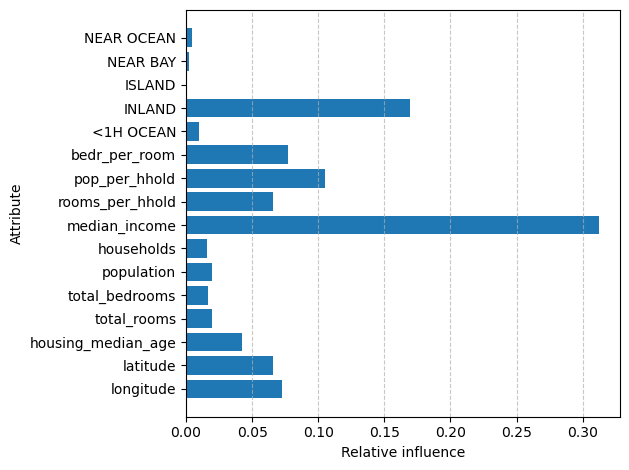

In [166]:
import seaborn as sns

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedr_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

importance_df = pd.DataFrame({'Attributes':attributes, 'Importance':features_importance})

plt.barh(importance_df['Attributes'], importance_df['Importance'])
plt.xlabel('Relative influence')
plt.ylabel('Attribute')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

#### Evaluating the model with the test set

In [149]:
from sklearn.metrics import mean_squared_error

best_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_final = full_pipeline.transform(X_test)

predictions = best_model.predict(X_test_final)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
print("Final rmse: ", final_rmse)

Final rmse:  49287.921726483335


In [150]:
from scipy import stats

confidence = 0.95
squared_errors = (predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc = squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([47542.15460584, 50973.93443385])